## This script will be used to test different aspects of 3D Object Detection for the nuPDM dataset.

In [28]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import gzip
import json
import cv2

np.set_printoptions(precision=4, suppress=True)

IMAGE = "CAM_FRONT"
ITEM = "0040"

# DATAROOT = "/home/nupdm/workspace/Datasets/PDM_Lite_FSG/devtest_full_6_cams"
# DATAROOT = "/home/nupdm/Datasets/PDM_Lite_FSG/routes_kitti_test/"

DATAROOT = "/home/nupdm/Datasets/nuPDM/routes_training_mini/route_0_routes_training_date_03_04_13_55_31/"

CAM_FRONT = os.path.join(DATAROOT, "val", "CAM_FRONT")
CAM_FRONT_LEFT = os.path.join(DATAROOT, "val", "CAM_FRONT_LEFT")
CAM_FRONT_RIGHT = os.path.join(DATAROOT, "val", "CAM_FRONT_RIGHT")
CAM_BACK = os.path.join(DATAROOT, "val", "CAM_BACK")
CAM_BACK_LEFT = os.path.join(DATAROOT, "val", "CAM_BACK_LEFT")
CAM_BACK_RIGHT = os.path.join(DATAROOT, "val", "CAM_BACK_RIGHT")
CALIB_PATH = os.path.join(DATAROOT, "calib")
MEASUREMENTS_PATH = os.path.join(DATAROOT, "measurements")
BOXES_PATH = os.path.join(DATAROOT, "boxes")

# load measurements
with gzip.open(os.path.join(MEASUREMENTS_PATH, ITEM + ".json.gz"), "rb") as f:
    measurements = json.load(f)

# load boxes
with gzip.open(os.path.join(BOXES_PATH, ITEM + ".json.gz"), "rb") as f:
    boxes = json.load(f)

# load calibration
with open(os.path.join(CALIB_PATH, ITEM + ".txt")) as f:
    calib = f.readlines()

CAM_FRONT_K = np.array([float(info) for info in calib[0].split(' ')[1:10]
                            ]).reshape([3, 3])

LIDAR2CAM_FRONT = np.array([float(info) for info in calib[6].split(' ')[1:17]
                            ]).reshape([4, 4])

print(f"Camera K matrix: {CAM_FRONT_K}")
print(f"Lidar to camera front matrix: {LIDAR2CAM_FRONT}")

lidar2img = CAM_FRONT_K @ LIDAR2CAM_FRONT[:3, :]

print(f"Lidar to image matrix: {lidar2img}")

# camera K matrix
cam_front_K = np.array(boxes[0]["cam_front_K"])
cam_front_T = np.array(boxes[0]["cam_front_T"])

# convert cam_front_T from (x, y, z) to (y, -z, x)
# cam_front_T = np.array([cam_front_T[1], -cam_front_T[2], cam_front_T[0]])

agent_position = np.array(boxes[1]["position"])
agent_extent = np.array(boxes[1]["extent"]) * 2
agent_yaw = boxes[1]["yaw"]

print(f"Agent position: {agent_position}")
print(f"Agent extent: {agent_extent}")
print(f"Agent yaw: {agent_yaw}")

Camera K matrix: [[1.14251841e+03 0.00000000e+00 8.00000000e+02]
 [0.00000000e+00 1.14251841e+03 4.50000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Lidar to camera front matrix: [[ 1.     0.     0.    -0.756]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.34 ]
 [ 0.     0.     0.     1.   ]]
Lidar to image matrix: [[ 1.14251841e+03  0.00000000e+00  8.00000000e+02 -5.91743914e+02]
 [ 0.00000000e+00  1.14251841e+03  4.50000000e+02  1.53000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  3.40000000e-01]]
Agent position: [-33.26040909   0.11604999  -0.2438261 ]
Agent extent: [4.67363882 1.81181252 1.44194734]
Agent yaw: -0.0005953496616868392


In [29]:
def load_image(path):
    return cv2.imread(path)

def load_agent_data(boxes_data):
    car_positions = []
    car_extents = []
    car_yaws = []
    for box_data in boxes_data:
        if box_data["class"] == "car" or box_data["class"] == "static_car":
            car_positions.append(box_data["position"])
            car_extents.append(box_data["extent"])
            car_yaws.append(box_data["yaw"])
    if len(car_positions) > 0:
            return car_positions, car_extents, car_yaws
    else:
        return None, None, None
    
def get_3d_bbox(position, extent, yaw, cam_T):
    R = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
     
    l, w, h = np.array(extent) * 2
    vertices_3d = np.array([
        [l/2, w/2, -h],
        [l/2, w/2, 0],
        [l/2, -w/2, -h],
        [l/2, -w/2, 0],
        [-l/2, w/2, -h],
        [-l/2, w/2, 0],
        [-l/2, -w/2, -h],
        [-l/2, -w/2, 0],
    ])
    
    # vertices_global = (R @ vertices_3d.T).T + position

    # extrinsic transform
    vertices_global_h = np.hstack([vertices_3d, np.ones((8, 1))])
    vertices_global = np.dot(cam_T, vertices_global_h.T).T[:, :3]

    # change from x, y, z to y, z, x
    vertices_global = vertices_global[:, [1, 2, 0]]
    # vertices_global[:, 1] = vertices_global[:, 1]           # INVERTIR Z EN MATRICES O NO INVERTIRLA AQUI REMEBER MAÑANA

    return vertices_global

def draw_3d_bbox(img, vertices, K):
    vertices_img = np.dot(K, vertices.T).T
    vertices_img[:, 0] /= vertices_img[:, 2]
    vertices_img[:, 1] /= vertices_img[:, 2]
    vertices_img = vertices_img[:, :2].astype(int)

    edges = [[0,1], [1,3], [3,2], [2,0], [0,4], [4,5], [5,1], [5,7], [7,6], [6,4], [6,2], [7,3]]

    for edge in edges:
        cv2.line(img, tuple(vertices_img[edge[0]]), tuple(vertices_img[edge[1]]), (0, 255, 0), 2)

    for vertex in vertices_img:
        cv2.circle(img, tuple(vertex), 5, (255, 0, 0), -1)

    return img

def build_projection_matrix(w, h, fov):
    f = w / (2 * np.tan(fov / 2))
    return np.array([
        [f, 0, w / 2],
        [0, f, h / 2],
        [0, 0, 1]
    ])

def draw_3d_center(img, center, K):

    # convert point from x, y, z to y, -z, x
    center = center[[1, 2, 0]]
    center[1] = -center[1]

    center_img = np.dot(K, center.T)

    center_img /= center_img[2]
    center_img = center_img[:2].astype(int)

    print(center_img)

    cv2.circle(img, tuple(center_img), 5, (255, 0, 0), -1)

    return img

In [31]:
# same with back camera

# BACK: 0, 1, 5. 6
# FRONT: 2, 3, 4

K_front = np.array(boxes[0]["cam_front_K"])
T_front = np.array(boxes[0]["cam_front_T"])
K_back = np.array(boxes[0]["cam_back_K"])
T_back = np.array(boxes[0]["cam_back_T"])

car_positions, car_extents, car_yaws = load_agent_data(boxes)

print(f"len(car_positions): {len(car_positions)}")

print(f"Car positions: {car_positions}")

img_front = cv2.imread(os.path.join(CAM_FRONT, ITEM + ".jpg"))
img_back = cv2.imread(os.path.join(CAM_BACK, ITEM + ".jpg"))

front_items = [2, 3, 4]
back_items = [0, 1, 5, 6]

for i in range(len(car_positions)):
    if car_positions[i][0] > 0:
        vertices = get_3d_bbox(car_positions[i], car_extents[i], car_yaws[i], T_front)
        img = draw_3d_bbox(img_front, vertices, K_front)

fig = plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

for i in range(len(car_positions)):
    if car_positions[i][0] < 0 and np.linalg.norm(car_positions[i]) > 6:
        vertices = get_3d_bbox(car_positions[i], car_extents[i], car_yaws[i], T_back)
        img = draw_3d_bbox(img_back, vertices, K_back)

fig = plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

len(car_positions): 24
Car positions: [[-33.26040909085884, 0.11604999407128958, -0.24382609785429388], [32.6282277669261, 0.03558941329862364, 0.25800020729922535], [28.970290034612617, -3.1103144453550158, 0.23127835408157305], [8.164669754284887, 2.3488370817361215, 0.075595716344238], [-13.819758268455303, -3.0927531217289186, -0.10102417861583746], [-36.90800031569893, -5.74484969833469, -0.2605895100117248], [-31.257975723293498, 2.777540782929492, -0.21683737396153724], [30.72925429129282, -5.777143784689827, 0.25379095854644307], [-3.0889587407530144, -5.761027956750809, 0.0031975825194865415], [-19.985780040062195, 2.7721092056517875, -0.128530934583845], [30.73878672935814, 2.7479419125999414, 0.2533406030214058], [19.456509518326243, -5.771832838706615, 0.17088032049421464], [-19.998242316061692, -5.752969859828141, -0.12808291206460343], [-36.89456119894123, 2.7802271552850186, -0.2610570986350953], [-25.621878154769547, 2.774855513675959, -0.1726536397245515], [-8.71455763

AttributeError: 'NoneType' object has no attribute 'shape'

In [29]:
import pickle

# open 

PATH = "/home/nupdm/Datasets/PDM_Lite_FSG/routes_devtest_routeroutes_devtest_route0_02_17_12_51_29_02_17_12_51_29/kitti_dbinfos_train.pkl"
PATH_2 = "/home/nupdm/Datasets/PDM_Lite_FSG/routes_devtest_routeroutes_devtest_route0_02_17_12_51_29_02_17_12_51_29/kitti_infos_train.pkl"


with open(PATH, "rb") as f:
    kitti_dbinfos = pickle.load(f)

# with open(PATH_2, "rb") as f:
#     kitti_infos = pickle.load(f)

print(kitti_dbinfos)

FileNotFoundError: [Errno 2] No such file or directory: '/home/nupdm/Datasets/PDM_Lite_FSG/routes_devtest_routeroutes_devtest_route0_02_17_12_51_29_02_17_12_51_29/kitti_dbinfos_train.pkl'

# NEW TEST FOR PROJECTION

(24, 3)
(3, 4)


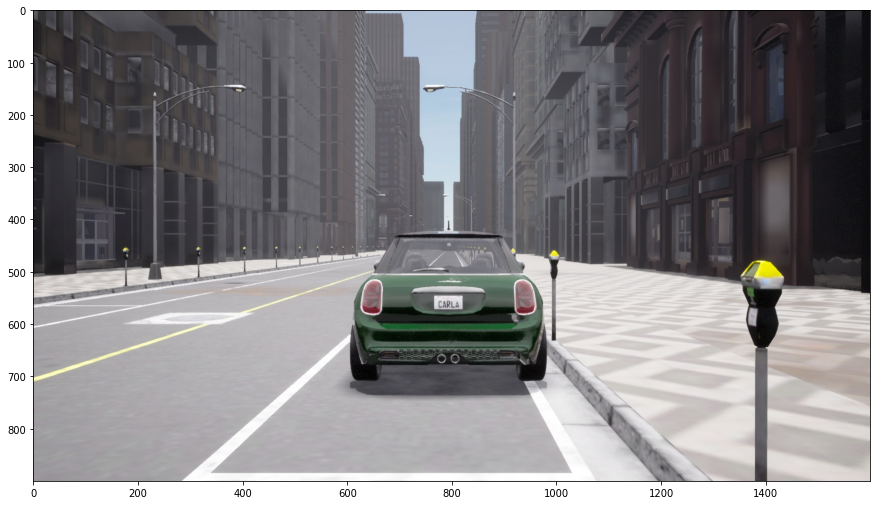

tensor([[  -560.7066,  -6791.4648],
        [   854.7652,  -6791.4648],
        [   854.7652,  -2266.5752],
        [  -560.7066,  -2266.5752],
        [  3763.0115,  16218.6767],
        [   680.7458,  16218.6767],
        [   680.7458,   6365.4878],
        [  3763.0115,   6365.4878],
        [ -8638.0477,  -4348.2927],
        [ -7228.2174,  -4348.2927],
        [ -7228.2174,    454.9881],
        [ -8638.0477,    454.9881],
        [ 23768.6634,  12127.2423],
        [ 20337.6661,  12127.2423],
        [ 20337.6661,    437.8609],
        [ 23768.6634,    437.8609],
        [  6770.7842,  -3268.5182],
        [  8204.2656,  -3268.5182],
        [  8204.2656,    424.4866],
        [  6770.7842,    424.4866],
        [-11412.9676,   8056.0600],
        [-14345.0887,   8056.0600],
        [-14345.0887,    502.1865],
        [-11412.9676,    502.1865]], dtype=torch.float64)


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

points_3d = np.array([[-8.1900e-01, -8.3819e+00,  9.8245e-01],
        [ 8.1939e-01, -8.3819e+00,  9.8245e-01],
        [ 8.1939e-01, -3.1444e+00,  9.8245e-01],
        [-8.1900e-01, -3.1444e+00,  9.8245e-01],
        [-8.1900e-01, -8.3819e+00, -9.4731e-01],
        [ 8.1939e-01, -8.3819e+00, -9.4731e-01],
        [ 8.1939e-01, -3.1444e+00, -9.4731e-01],
        [-8.1900e-01, -3.1444e+00, -9.4731e-01],
        [-9.7871e+00, -5.3601e+00,  9.3629e-01],
        [-8.2122e+00, -5.3601e+00,  9.3629e-01],
        [-8.2122e+00,  5.5721e-03,  9.3629e-01],
        [-9.7871e+00,  5.5721e-03,  9.3629e-01],
        [-9.7871e+00, -5.3601e+00, -8.6444e-01],
        [-8.2122e+00, -5.3601e+00, -8.6444e-01],
        [-8.2122e+00,  5.5721e-03, -8.6444e-01],
        [-9.7871e+00,  5.5721e-03, -8.6444e-01],
        [ 8.1168e+00, -4.5842e+00,  1.0685e+00],
        [ 9.8840e+00, -4.5842e+00,  1.0685e+00],
        [ 9.8840e+00, -3.1453e-02,  1.0685e+00],
        [ 8.1168e+00, -3.1453e-02,  1.0685e+00],
        [ 8.1168e+00, -4.5842e+00, -1.0286e+00],
        [ 9.8840e+00, -4.5842e+00, -1.0286e+00],
        [ 9.8840e+00, -3.1453e-02, -1.0286e+00],
        [ 8.1168e+00, -3.1453e-02, -1.0286e+00]])

print(points_3d.shape)

proj_mat = np.array([[ 1.14251841e+03,  0.00000000e+00,  8.00000000e+02, -5.91743914e+02],
 [ 0.00000000e+00,  1.14251841e+03,  4.50000000e+02,  1.53000000e+02],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  3.40000000e-01]])

print(proj_mat.shape)

IMG_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_mini/route_0_routes_training_date_03_04_13_55_31/CAM_FRONT/0000.jpg"

# load and show
img = cv2.imread(IMG_PATH)
fig = plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

points_4 = torch.cat([torch.from_numpy(points_3d), torch.ones((24, 1))], dim=-1)

points_2d = points_4 @ torch.from_numpy(proj_mat).T
point_2d_res = points_2d[:, :2] / points_2d[:, 2:]

print(point_2d_res)